### Preprocess sales to find seasonality. Apply to Corporacion Favorita

Extract the trend using LOESS and derive a heartbeat monitor from it

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fcn_helpers as fhelp
import fcn_simulation as fsim
import statsmodels.tsa.seasonal as seasonal_methods
plt.rcParams['figure.figsize'] = [14, 7]
fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10
fig_w = 18

In [2]:
outputBaseFolder = '/Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/CorporacionFavorita'
mapper_family_to_category = fhelp.cfav_get_map_dept_to_cat()

In [3]:
store = 'Pichincha_47_A_14'
dept_id = 'PRODUCE'

In [4]:
category_id = mapper_family_to_category.get(dept_id, '')

In [5]:
# Read the stores data
#/FOOD/MEATS/store_sales/El_Oro_40.pickle
store_filepath = os.path.join(outputBaseFolder, category_id, dept_id, 'store_sales', f'{store}.pickle')
df_store = fhelp.readPickleFile(store_filepath)

sales_vars = [iVar for iVar in df_store.columns if 'sales-' in iVar]
promotion_vars = [iVar for iVar in df_store.columns if 'promotion_flag-' in iVar]

df_store.head(3)

,date,weekdays,sales-PRODUCE_1149069-Pichincha_47_A_14,promotion_flag-PRODUCE_1149069-Pichincha_47_A_14,sales-PRODUCE_1473393-Pichincha_47_A_14,promotion_flag-PRODUCE_1473393-Pichincha_47_A_14,sales-PRODUCE_1473394-Pichincha_47_A_14,promotion_flag-PRODUCE_1473394-Pichincha_47_A_14,sales-PRODUCE_1473396-Pichincha_47_A_14,promotion_flag-PRODUCE_1473396-Pichincha_47_A_14,...,promotion_flag-PRODUCE_2037487-Pichincha_47_A_14,sales-PRODUCE_2040637-Pichincha_47_A_14,promotion_flag-PRODUCE_2040637-Pichincha_47_A_14,sales-PRODUCE_2042210-Pichincha_47_A_14,promotion_flag-PRODUCE_2042210-Pichincha_47_A_14,sales-PRODUCE_2049081-Pichincha_47_A_14,promotion_flag-PRODUCE_2049081-Pichincha_47_A_14,sales-PRODUCE_2111870-Pichincha_47_A_14,promotion_flag-PRODUCE_2111870-Pichincha_47_A_14,total_units
0,2017-01-01,Sunday,0.0,False,0.000,False,0.000,False,0.000,False,...,False,0.0,False,0.0,False,0.0,False,0.0,False,0.000
1,2017-01-02,Monday,19.0,False,94.504,False,79.284,False,16.726,False,...,False,0.0,False,0.0,False,0.0,False,0.0,False,10746.390
2,2017-01-03,Tuesday,8.0,False,56.715,False,48.890,False,14.242,False,...,False,0.0,False,0.0,False,0.0,False,0.0,False,8496.695


### Naive-Projection 

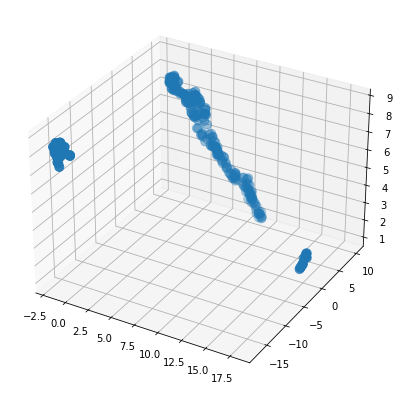

In [17]:
data_to_reduce = df_store[sales_vars].T.values
n_components = 3
umap_projected_data = fhelp.draw_umap(data_to_reduce,  n_neighbors=5, n_components=n_components)

In [18]:
df_embedding = pd.DataFrame(umap_projected_data, columns=[f'd{idx}' for idx in range(0, n_components)])
df_embedding['sku'] = sales_vars
df_embedding['sku'] = df_embedding['sku'].apply(lambda s: s.split('-')[1])
df_embedding.head()

,d0,d1,d2,sku
0,3.555912,8.021672,6.844849,PRODUCE_1149069
1,9.146735,9.536438,1.135285,PRODUCE_1473393
2,9.085798,9.616272,1.238982,PRODUCE_1473394
3,2.937062,7.406851,6.464772,PRODUCE_1473396
4,2.359203,6.963433,7.323954,PRODUCE_1473401


In [ ]:
df_store[sales_vars].sum(axis=0).sort_values(ascending=False).head()

### Back to the sales

In [7]:
sku_name = 'PRODUCE_1473393'

In [14]:
x_axis = df_store.date
sku_sales = df_store[f'sales-{sku_name}-{store}']
sku_promos = df_store[f'promotion_flag-{sku_name}-{store}']

num_promos = sku_promos.sum()
print(f'Num promos {num_promos}')

df_store.weekdays[sku_promos].value_counts()

Num promos 32


Wednesday    32
Name: weekdays, dtype: int64

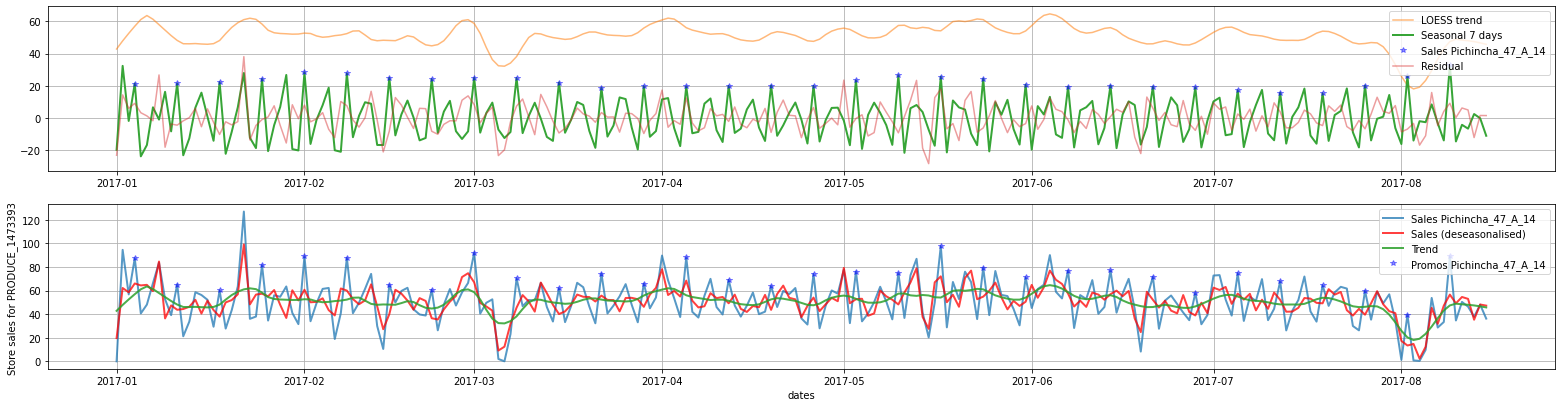

In [15]:
# Input signal using LOESS

period_in_days=7

df_decomposition = seasonal_methods.STL(sku_sales, period=period_in_days).fit()

xaxis = df_store.date
# Plot one store
f, ax = plt.subplots(2,1,figsize=(fig_w*1.5, fig_h/1.5))

idx_axis = 0

ax[0].plot(x_axis, df_decomposition.trend, label=f'LOESS trend', 
        color=def_colours[idx_store+1], linewidth=1.5, alpha=0.55)

ax[0].plot(x_axis, df_decomposition.seasonal, label=f'Seasonal {period_in_days} days', 
        color=def_colours[idx_store+2], linewidth=2.0, alpha=0.95)

ax[0].plot(x_axis[sku_promos], df_decomposition.seasonal[sku_promos], '*', label=f'Sales {store}', 
        color='b', linewidth=2, alpha=0.45)

ax[0].plot(x_axis, df_decomposition.resid, label=f'Residual', 
        color=def_colours[idx_store+3], linewidth=1.5, alpha=0.45)


ax[0].grid(True)
ax[0].legend()

deseasonalised_signal = df_decomposition.trend + df_decomposition.resid


ax[1].plot(x_axis, sku_sales, label=f'Sales {store}', 
        color=def_colours[idx_store], linewidth=2, alpha=0.75)

ax[1].plot(x_axis, deseasonalised_signal, label=f'Sales (deseasonalised)', 
        color='r', linewidth=2, alpha=0.75)

ax[1].plot(x_axis, df_decomposition.trend, label=f'Trend', 
        color=def_colours[idx_store+2], linewidth=2, alpha=0.85)

ax[1].plot(x_axis[sku_promos], sku_sales[sku_promos], '*', label=f'Promos {store}', 
        color='b', linewidth=2, alpha=0.45)
ax[1].legend()

plt.xlabel('dates')
plt.ylabel(f'Store sales for {sku_name} ')
plt.grid(True)
plt.show()

In [8]:
#fhelp.to_random_excel_file(df_store[[f'sales-{sku_name}', f'promotion_flag-{sku_name}']])

In [10]:
# Season-Trend decomposition using LOESS.
df_decomposition = fhelp.decompose_signal(sku_sales, period_in_days=14, minimum_heartbeat=0.25)
df_decomposition.head()
#heartbeat_flag

,heartbeat_flag,trend,seasonal,residual
0,True,42.800951,-19.710199,-23.090753
1,True,47.821638,32.343363,14.338999
2,True,52.482605,-1.802934,6.035328
3,True,56.913512,21.386868,9.089620
4,True,61.074462,-23.761431,3.279969


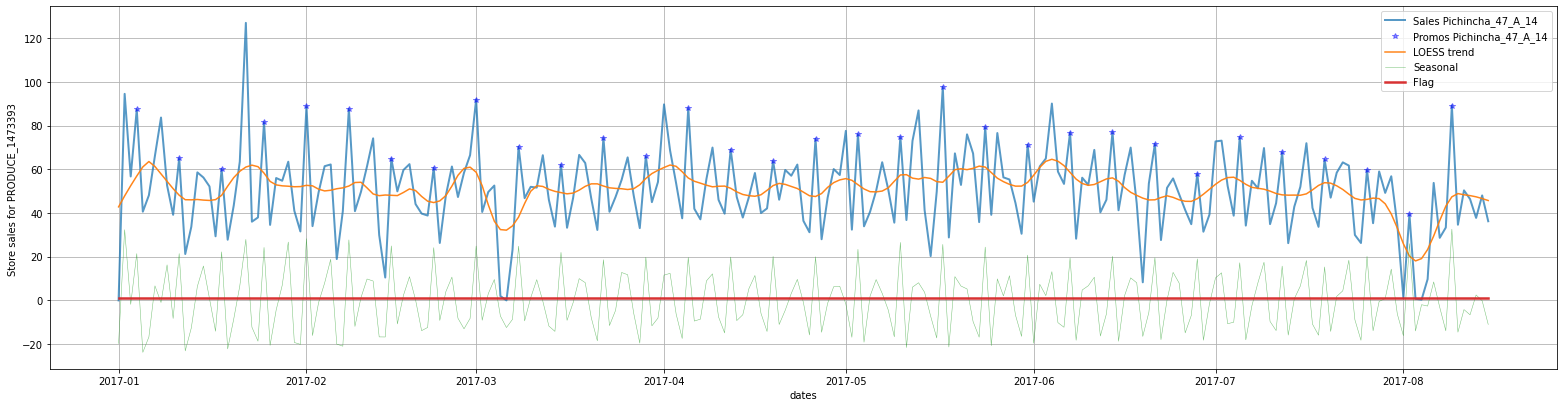

In [13]:
xaxis = df_store.date
# Plot one store
f, ax = plt.subplots(1,1,figsize=(fig_w*1.5, fig_h/1.5))

idx_store = 0
ax.plot(x_axis, sku_sales, label=f'Sales {store}', 
        color=def_colours[idx_store], linewidth=2, alpha=0.75)

ax.plot(x_axis[sku_promos], sku_sales[sku_promos], '*', label=f'Promos {store}', 
        color='b', linewidth=1, alpha=0.45)

ax.plot(x_axis, df_decomposition.trend, label=f'LOESS trend', 
        color=def_colours[idx_store+1], linewidth=1.5, alpha=0.95)

ax.plot(x_axis, df_decomposition.seasonal, label=f'Seasonal', 
        color=def_colours[idx_store+2], linewidth=0.5, alpha=0.65)


ax.plot(x_axis, df_decomposition.heartbeat_flag, label=f'Flag', 
        color=def_colours[idx_store+3], linewidth=2.5, alpha=0.95)

plt.legend()
plt.xlabel('dates')
plt.ylabel(f'Store sales for {sku_name} ')
plt.grid(True)
plt.show()

### Comparisons

In [15]:
df_decomposition = fhelp.decompose_signal(sku_sales, period_in_days=period_in_days, minimum_heartbeat=0.85)
df_decomposition.head()
#a,b = fhelp.measure_strength_decomposition(df_decomposition)

,heartbeat_flag,trend,seasonal,residual
0,True,42.800951,-19.710199,-23.090753
1,True,47.821638,32.343363,14.338999
2,True,52.482605,-1.802934,6.035328
3,True,56.913512,21.386868,9.089620
4,True,61.074462,-23.761431,3.279969


### Decompose the full department_id

In [32]:
department_sales = df_store['total_units'].values
period_in_days = 7
df_decomposition = fhelp.decompose_signal(department_sales, period_in_days=period_in_days, minimum_heartbeat=0.85)

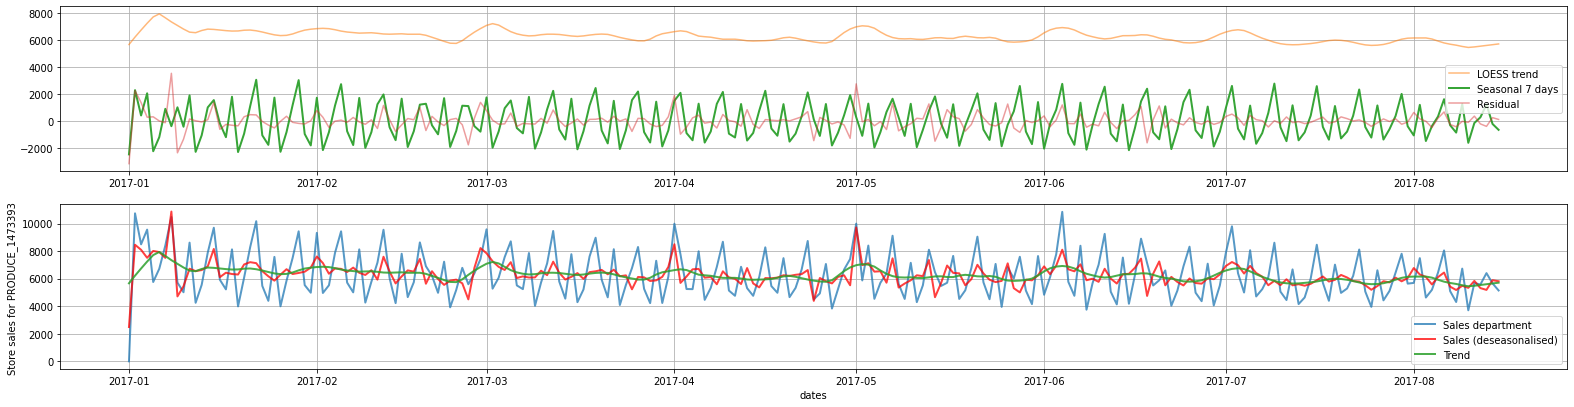

In [34]:
# Input signal using LOESS

xaxis = df_store.date
# Plot one store
f, ax = plt.subplots(2,1,figsize=(fig_w*1.5, fig_h/1.5))

idx_axis = 0

ax[0].plot(x_axis, df_decomposition.trend, label=f'LOESS trend', 
        color=def_colours[idx_store+1], linewidth=1.5, alpha=0.55)

ax[0].plot(x_axis, df_decomposition.seasonal, label=f'Seasonal {period_in_days} days', 
        color=def_colours[idx_store+2], linewidth=2.0, alpha=0.95)

'''ax[0].plot(x_axis[sku_promos], df_decomposition.seasonal[sku_promos], '*', label=f'Sales {store}', 
        color='b', linewidth=2, alpha=0.45)'''

ax[0].plot(x_axis, df_decomposition.residual, label=f'Residual', 
        color=def_colours[idx_store+3], linewidth=1.5, alpha=0.45)


ax[0].grid(True)
ax[0].legend()

deseasonalised_signal = df_decomposition.trend + df_decomposition.residual


ax[1].plot(x_axis, department_sales, label=f'Sales department', 
        color=def_colours[idx_store], linewidth=2, alpha=0.75)

ax[1].plot(x_axis, deseasonalised_signal, label=f'Sales (deseasonalised)', 
        color='r', linewidth=2, alpha=0.75)

ax[1].plot(x_axis, df_decomposition.trend, label=f'Trend', 
        color=def_colours[idx_store+2], linewidth=2, alpha=0.85)

'''ax[1].plot(x_axis[sku_promos], sku_sales[sku_promos], '*', label=f'Promos {store}', 
        color='b', linewidth=2, alpha=0.45)'''
ax[1].legend()

plt.xlabel('dates')
plt.ylabel(f'Store sales for {sku_name} ')
plt.grid(True)
plt.show()

In [1]:
es_alpha = 0.5
current_day = 7
es_alpha*(1-es_alpha)**current_day

0.00390625